# Metacritic Score Datasets (Feb 2023)

## Load Packages and Functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
import pickle


## Load Data 

In [2]:
df_movies = pd.read_csv('../../data/processed/df_movies_processed.csv')

In [3]:
df_movies.columns

Index(['Unnamed: 0', 'metascore', 'rating', 'release_date', 'sort_no',
       'summary', 'title', 'user_score', 'release_year', 'release_month',
       'release_quarter', 'release_yearday', 'title_len', 'summary_len',
       'title_wordlen', 'summary_wordlen', 'title_avg_wordlength',
       'summary_avg_wordlength', 'title_capcount', 'summary_capcount',
       'title_punccount', 'summary_punccount', 'title_sentcount',
       'summary_sentcount', 'title_uniq', 'summary_uniq',
       'title_uniq_vs_words', 'summary_uniq_vs_words', 'title_stopcount',
       'summary_stopcount', 'title_stopwords_vs_words',
       'summary_stopwords_vs_words', 'title_clean', 'summary_clean',
       'title_clean_num', 'summary_clean_num', 'title_topic', 'summary_topic'],
      dtype='object')

In [4]:
df_movies.drop(['Unnamed: 0','release_date','summary', 'title','title_clean','sort_no',
                'summary_clean', 'title_clean_num', 'summary_clean_num',
                'title_punccount','summary_punccount',
               'title_wordlen', 'summary_wordlen','title_uniq', 'summary_uniq'],axis=1,inplace=True)

In [5]:
df_movies.select_dtypes('object').value_counts()

rating   
R            4938
Not Rated    4025
PG-13        2586
PG           1472
-1           1124
TV-MA         260
G             230
TV-14         149
TV-PG         140
Approved      134
Passed         94
NC-17          83
TV-G           40
GP             23
M               9
M/PG            8
Open            6
TV-Y7           2
MA-17           1
TV-Y7-FV        1
Name: count, dtype: int64

<AxesSubplot: >

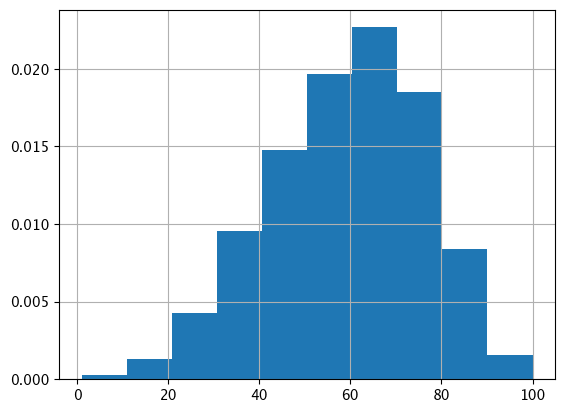

In [24]:
df_movies['metascore'].hist(density=True)

<AxesSubplot: >

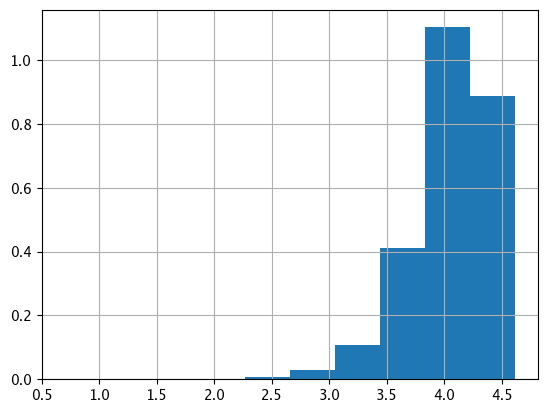

In [25]:
np.log1p(df_movies['metascore']).hist(density=True)

## Encoding

In [6]:
from sklearn.preprocessing import LabelEncoder
def label_encode_columns(dataframe, columns):
    """Label encodes the specified columns of a dataframe"""
    encoded_data = {}
    for column in columns:
        le = LabelEncoder()
        dataframe[column] = le.fit_transform(dataframe[column].astype('str'))
        le_classes = le.classes_
        encoded_data[column] = {"label_encoder": le, "classes": le_classes}
    return {"dataframe": dataframe, "encoded_data": encoded_data}

In [7]:
movies_encoding = label_encode_columns(df_movies, df_movies.select_dtypes('object').columns.values)

In [8]:
df_movies_encoded = movies_encoding['dataframe']

In [9]:
movies_encoding['encoded_data']['rating']['label_encoder'].transform(movies_encoding['encoded_data']['rating']['classes'])
movies_encoding['encoded_data']['rating']['classes']

array(['-1', 'Approved', 'G', 'GP', 'M', 'M/PG', 'MA-17', 'NC-17',
       'Not Rated', 'Open', 'PG', 'PG-13', 'Passed', 'R', 'TV-14', 'TV-G',
       'TV-MA', 'TV-PG', 'TV-Y7', 'TV-Y7-FV'], dtype=object)

## Feature Selection

## Train-Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_movies.drop('metascore',axis=1), 
                                                    df_movies['metascore'], 
                                                    test_size=0.30, random_state=42)

In [11]:
y_train.value_counts()

metascore
64    261
65    256
68    252
67    251
66    250
     ... 
8       4
99      3
7       3
5       2
6       1
Name: count, Length: 97, dtype: int64

In [12]:
X_train.columns

Index(['rating', 'user_score', 'release_year', 'release_month',
       'release_quarter', 'release_yearday', 'title_len', 'summary_len',
       'title_avg_wordlength', 'summary_avg_wordlength', 'title_capcount',
       'summary_capcount', 'title_sentcount', 'summary_sentcount',
       'title_uniq_vs_words', 'summary_uniq_vs_words', 'title_stopcount',
       'summary_stopcount', 'title_stopwords_vs_words',
       'summary_stopwords_vs_words', 'title_topic', 'summary_topic'],
      dtype='object')

In [13]:
X_train.head()

,rating,user_score,release_year,release_month,release_quarter,release_yearday,title_len,summary_len,title_avg_wordlength,summary_avg_wordlength,...,title_sentcount,summary_sentcount,title_uniq_vs_words,summary_uniq_vs_words,title_stopcount,summary_stopcount,title_stopwords_vs_words,summary_stopwords_vs_words,title_topic,summary_topic
1758,8,-1.0,2023.0,2.0,1.0,48.0,11,497,11.0,6.291139,...,1,3,1.0,0.797468,0,28,0.0,0.354430,21,-1
12152,7,6.5,2007.0,8.0,3.0,222.0,7,222,7.0,6.166667,...,1,3,1.0,0.888889,0,15,0.0,0.416667,-1,-1
10598,8,6.6,2014.0,10.0,4.0,276.0,13,172,6.5,7.166667,...,1,1,1.0,0.958333,0,7,0.0,0.291667,0,-1
852,13,7.6,2022.0,10.0,4.0,280.0,9,172,4.5,5.058824,...,1,2,1.0,0.882353,0,14,0.0,0.411765,1,-1
1494,0,8.0,2005.0,7.0,3.0,182.0,9,242,4.5,6.722222,...,1,2,1.0,0.944444,0,13,0.0,0.361111,-1,1


In [14]:
X_train['title_uniq_vs_words'].max()

1.0

## Model

In [15]:
#linear_reg = LinearRegression()
#decision_tree_reg = DecisionTreeRegressor(random_state = 42)
random_forest_reg = RandomForestRegressor(random_state = 42)
#xgboost_reg = XGBRegressor(seed = 42)

# Step 4: Hyperparameter Tuning
linear_reg_params = {}
decision_tree_reg_params = {'max_depth': [3, 5, 7]}
random_forest_reg_params = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}
xgboost_reg_params = {'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [3, 5, 7]}

#linear_reg_grid = GridSearchCV(linear_reg, linear_reg_params, cv=5)
#decision_tree_reg_grid = GridSearchCV(decision_tree_reg, decision_tree_reg_params, cv=5)
random_forest_reg_grid = GridSearchCV(random_forest_reg, random_forest_reg_params, cv=5)
#xgboost_reg_grid = GridSearchCV(xgboost_reg, xgboost_reg_params, cv=5)

#linear_reg_grid.fit(X_train, y_train)
#decision_tree_reg_grid.fit(X_train, y_train)
random_forest_reg_grid.fit(X_train, y_train)
#xgboost_reg_grid.fit(X_train, y_train)

# Step 5: Model Training
#linear_reg_model = linear_reg_grid.best_estimator_
#decision_tree_reg_model = decision_tree_reg_grid.best_estimator_
random_forest_reg_model = random_forest_reg_grid.best_estimator_
#xgboost_reg_model = xgboost_reg_grid.best_estimator_

In [16]:
#linear_reg_model.fit(X_train, y_train)
#print('Fitter LG')
#decision_tree_reg_model.fit(X_train, y_train)
#print('Fitter DT')
random_forest_reg_model.fit(X_train, y_train)
print('Fitter RF')
#xgboost_reg_model.fit(X_train, y_train)
#print('Fitter XGB')

Fitter RF


In [17]:
#y_pred_linear = linear_reg_model.predict(X_test)
#y_pred_dt = decision_tree_reg_model.predict(X_test)
y_pred_rf = random_forest_reg_model.predict(X_test)
#y_pred_xgb = xgboost_reg_model.predict(X_test)

In [29]:
Adj_r2 = 1 - (1-metrics.r2_score(y_test, y_pred_rf)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
# Step 5: Evaluate the model performance
print("RF: r-score = ",metrics.r2_score(y_test, y_pred_rf).round(5), ", MSE = ", 
      metrics.mean_squared_error(y_test, y_pred_rf).round(5),", MAPE = ",
      metrics.mean_absolute_percentage_error(y_test, y_pred_rf).round(5),
      ", RMSE = ",metrics.mean_squared_error(y_test, y_pred_rf, squared=False).round(5),
      ", ADJ-R2 = ", Adj_r2.round(5))

#LinearReg: r-score =  0.06906265014799318 , MSE =  270.2670437282094 , MAPE =  0.3174741959022944
#Decision Tree: r-score =  0.2943551034715307 , MSE =  204.8607891142896 , MAPE =  0.2632827766998192
#Random Forest: r-score =  0.33745079689923907 , MSE =  192.3493718186192 , MAPE =  0.2533494851491093
#XGBoost: r-score =  0.35155470318214177 , MSE =  188.25476646552448 , MAPE =  0.253455214202358

RF: r-score =  0.33727 , MSE =  192.40242 , MAPE =  0.25317 , RMSE =  13.87092 , ADJ-R2 =  0.33408


<AxesSubplot: xlabel='metascore'>

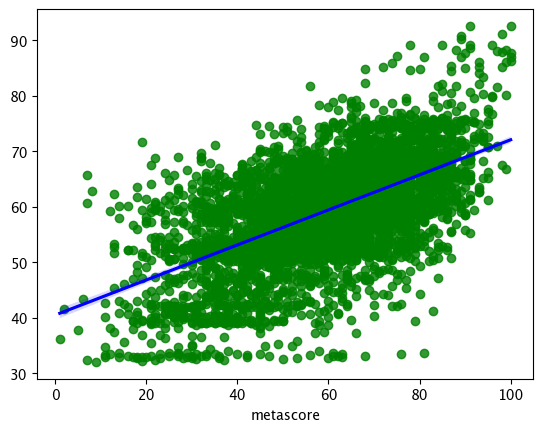

In [19]:
sns.regplot(x=y_test, y=y_pred_rf, scatter_kws={"color": "green"}, line_kws={"color": "blue"}) 

In [20]:
#xgboost_reg_model.best_ntree_limit

In [21]:
y_pred_rf = random_forest_reg_model.predict(X_test)

In [23]:
# save in JSON format
#xgboost_reg_model.save_model("../../models/xgboost_reg_model_metascore.pkl")
#joblib.dump(random_forest_reg_model, "random_forest_reg_model_metascore.joblib")

['random_forest_reg_model_metascore.joblib']

In [22]:
with open('../../models/random_forest_reg_model_metascore.pkl', 'wb') as f:
    pickle.dump(random_forest_reg_model, f)